In [1]:
import pandas as pd
from dataset_manager import DatasetManager
import seaborn as sns
from matplotlib import pyplot as plt
from pipeline import Pipeline

dataset_path = "./datasets"
manager = DatasetManager(dataset_path)
pipeline_fav = Pipeline("FavorecidosEContratos")

# Obter e preparad datasets
## Obter e converter colunas necessárias de `string` para `float`

In [2]:
def cast_serie_to_float(serie):
    return serie.apply(lambda x: float(x.replace(",",".")))

def get_ds_contrato(ano):
    contratos = manager.get_dataset("riotransparente_contratos_{}".format(ano))
    df_contratos = contratos.load_as_pandas(error_bad_lines=False, encoding='latin-1', sep=";")
   
    column_valores_contrato = ["Valor pago"]
    for clm in column_valores_contrato:
        nova_coluna = "{}_fmt".format(clm)
        df_contratos[nova_coluna]=cast_serie_to_float(df_contratos[clm])
    
    return df_contratos

def get_ds_favorecidos(ano):
    dataset = manager.get_dataset("riotransparente_favorecidos_{}".format(ano))
    df = dataset.load_as_pandas(error_bad_lines=False, encoding='latin-1', sep=";")
   
    colunas_valores=["vl anul liq rp","Vl pago", "Vl anul disp", "Vl anul emp", "Vl anul rp", 'Vl Soma Retencao', 'Vl inss',
       'Vl iss', 'Vl ir', 'Vl descontos', 'Vl multas', 'Vl csll', 'Vl cofins',
       'Vl pis pasep', 'Vl cofins pis pasep csll', 'Vl tafi', 'Vl tafc',
       'Vl trfc']

    for clm in colunas_valores:
        nova_coluna = "{}_fmt".format(clm)
        df[nova_coluna]=cast_serie_to_float(df[clm])
    
    return df

## Filtro para `Fonte do recurso == merenda escolar`

In [3]:
def filtro_merenda(df):
    return df [(~pd.isnull(df['Descrição da fonte de recursos']))&(df['Descrição da fonte de recursos'].str.contains("MERENDA ESCOLAR"))]

-----------

# Criação do pipeline de execução
cada função desse pipeline tem a seguinte assinatura: `(df_fav, df_cont, ano)`.
## 1 - Coparação entre valor pago total e valor aplicado em merenda

In [4]:
def comparacao_total(df_fav, df_cont, ano):
    df_merenda = filtro_merenda(df_fav)
    valor_merenda = df_merenda["Vl pago_fmt"].sum()
    valor_total = df_fav["Vl pago_fmt"].sum()
    print("O valor pago em merenda correpondeu a {}% do valor pago para Favorecidos no ano de {}".format((valor_merenda/valor_total)*100, ano))

In [5]:
pipeline_fav.add_function(comparacao_total)

## 2 - Quem são os 10 maiores favorecidos da merenda

In [6]:
def group_favorecidos(df):
    return df.groupby(by=['Favorecido',
                          'Código favorecido',
                          'Tipo favorecido',
                          'Descrição do tipo de favorecido'],
                      as_index=False).agg({'Vl pago_fmt':['sum', list]})

In [7]:
def top_favorecidos(df_fav, df_cont, ano):
    df_merenda = filtro_merenda(df_fav)
    grouped_merenda =group_favorecidos(df_merenda)
    top_ten = grouped_merenda.sort_values(by=[('Vl pago_fmt','sum')], ascending=False).head(10)

    top_ten["Valor Pago"] = top_ten["Vl pago_fmt"]["sum"]/1000000

    plt.figure(figsize=(16, 6))
    sns.barplot(data=top_ten, x="Favorecido", y="Valor Pago")
    plt.xticks(rotation=90)
    plt.title("Top 10 favorecidos da merenda em {}".format(ano))
    plt.ylabel("Valor Pago (Milhões)")

In [8]:
pipeline_fav.add_function(top_favorecidos)

## 3 - Cruzamento entre Favorecidos e contratos
### Existe algum valor pago fora dos contratos?

In [9]:
def favorecidos_contratos(df_fav, df_cont, ano):
    
    df_fav_merenda = filtro_merenda(df_fav)
    df_fav_merenda_grouped = group_favorecidos(df_fav_merenda)
    
    df_contratos_merenda = filtro_merenda(df_cont)
    df_contratos_merenda_grouped = df_contratos_merenda.groupby(by=['Favorecido','Código favorecido'],
                                         as_index=False).agg({'Valor pago_fmt':['sum', list]})

    fav_contrato = df_fav_merenda_grouped.join(
        df_contratos_merenda_grouped.set_index("Código favorecido"),
        how='left',
        on="Código favorecido",
        lsuffix='_fav',
        rsuffix='_cont')
    
    fav_contrato["Dif(fav-cont)"] =  fav_contrato["Vl pago_fmt"]["sum"] - fav_contrato["Valor pago_fmt"]["sum"]
    
    fav_contrato_plot = fav_contrato[fav_contrato["Dif(fav-cont)"] != 0.0]
    fav_contrato_plot["Dif(fav-cont)(M)"] = fav_contrato_plot["Dif(fav-cont)"]/1000000

    plt.figure(figsize=(16, 6))
    sns.barplot(data=fav_contrato_plot, x="Favorecido_fav", y="Dif(fav-cont)(M)")
    plt.xticks(rotation=90)
    plt.title("Diferença entre valor pago por favorecido e valor em contratos {}".format(ano))
    plt.ylabel("Diferença (Pago total por Favorecido - Pago em contratos) (Milhões)")
    

In [10]:
pipeline_fav.add_function(favorecidos_contratos)

------
# Execução do Pipeline

## 2018

/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


O valor pago em merenda correpondeu a 0.25670187123716254% do valor pago para Favorecidos no ano de 2018


/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


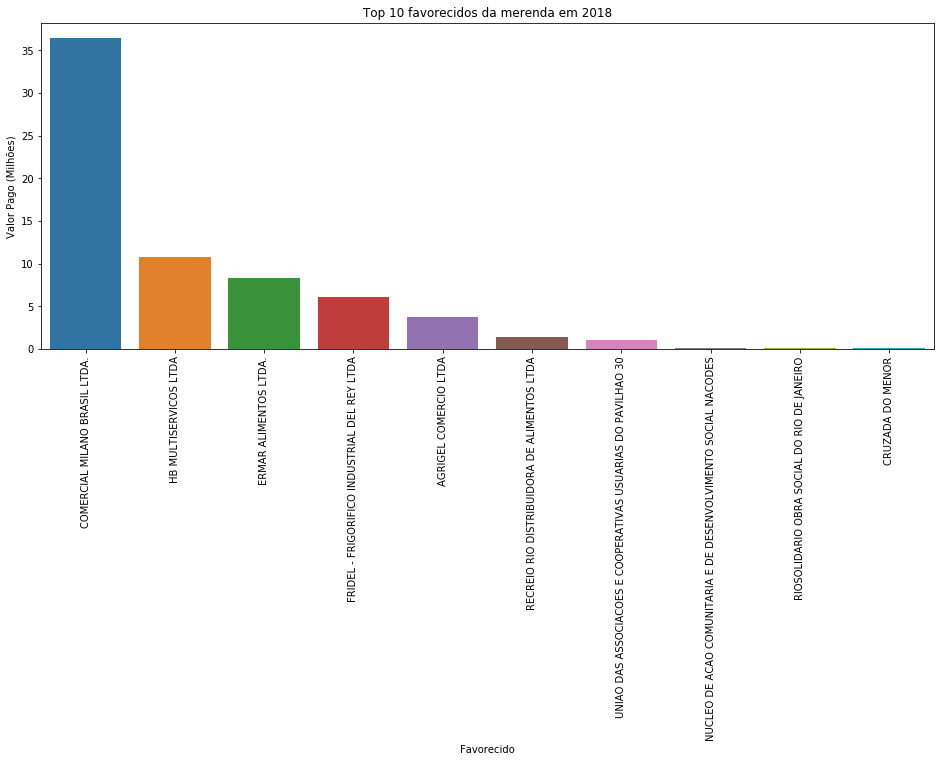

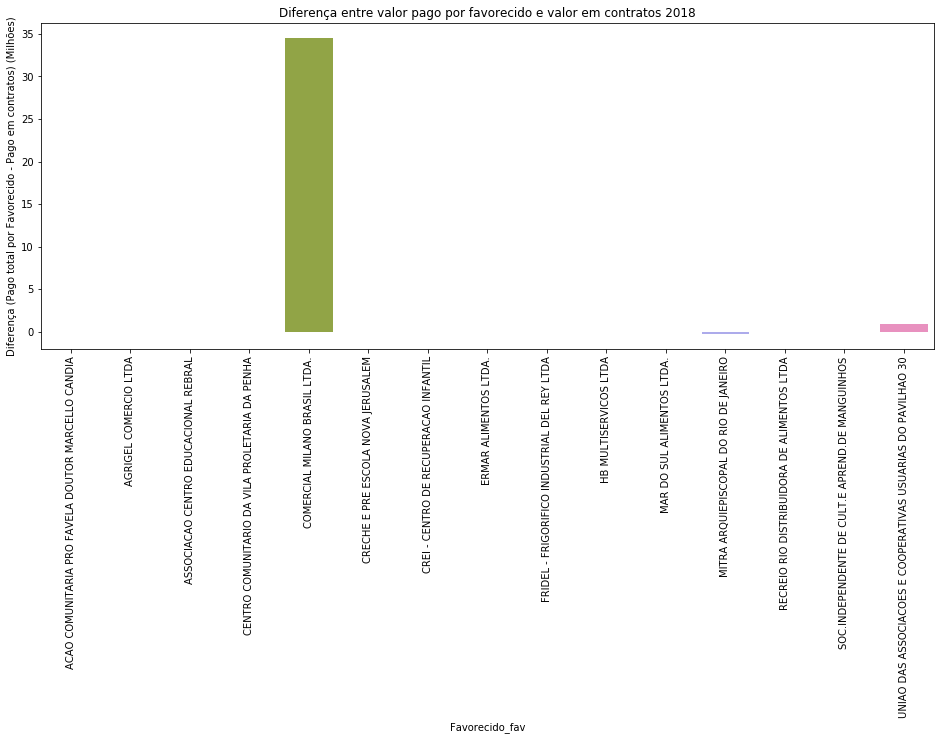

In [11]:
df_fav_2018 = get_ds_favorecidos(2018)
df_cont_2018 = get_ds_contrato(2018)

pipeline_fav.run(df_fav_2018, df_cont_2018, 2018)

## 2017

/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (14,16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


O valor pago em merenda correpondeu a 0.29808951123914734% do valor pago para Favorecidos no ano de 2017


/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


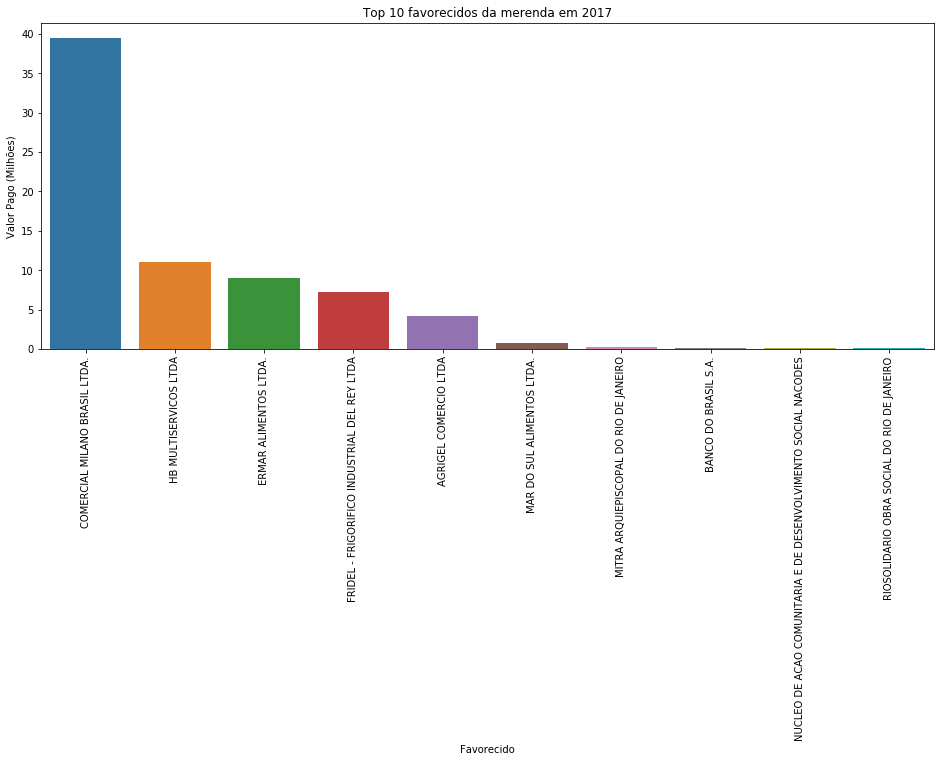

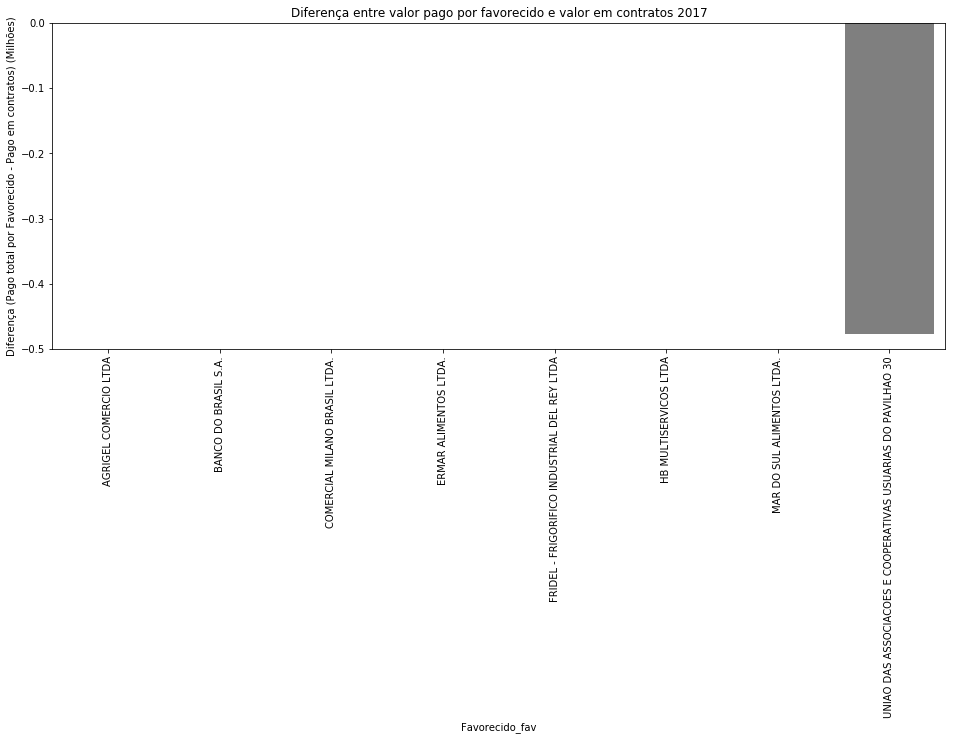

In [12]:
df_fav_2017 = get_ds_favorecidos(2017)
df_cont_2017 = get_ds_contrato(2017)

pipeline_fav.run(df_fav_2017, df_cont_2017, 2017)

## 2016

/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


O valor pago em merenda correpondeu a 0.2594132707848217% do valor pago para Favorecidos no ano de 2016


/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


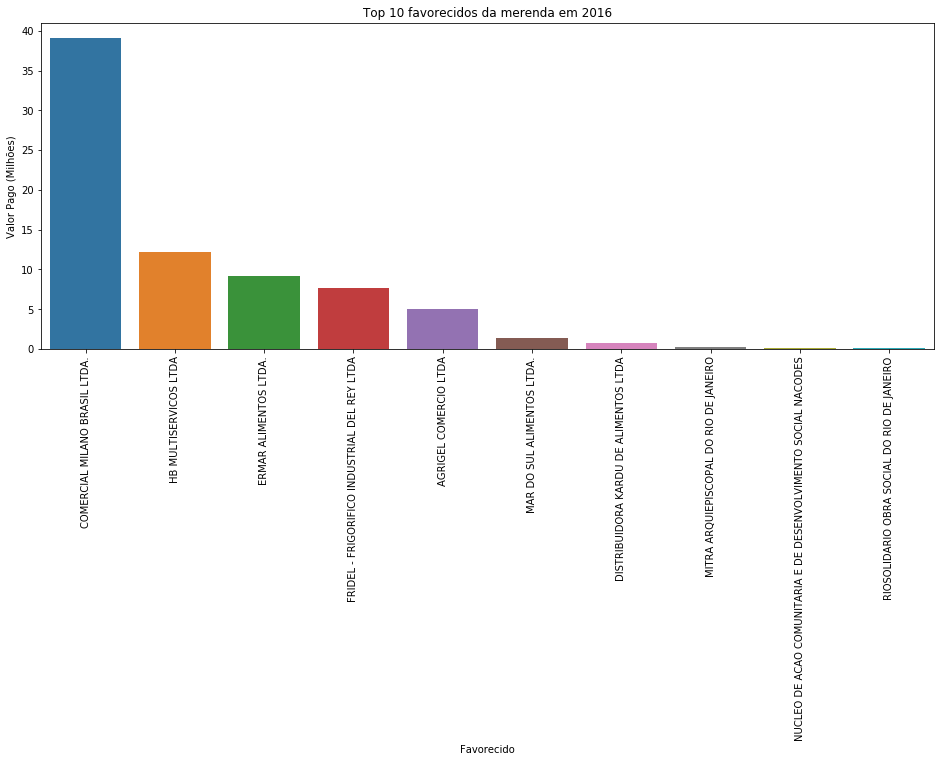

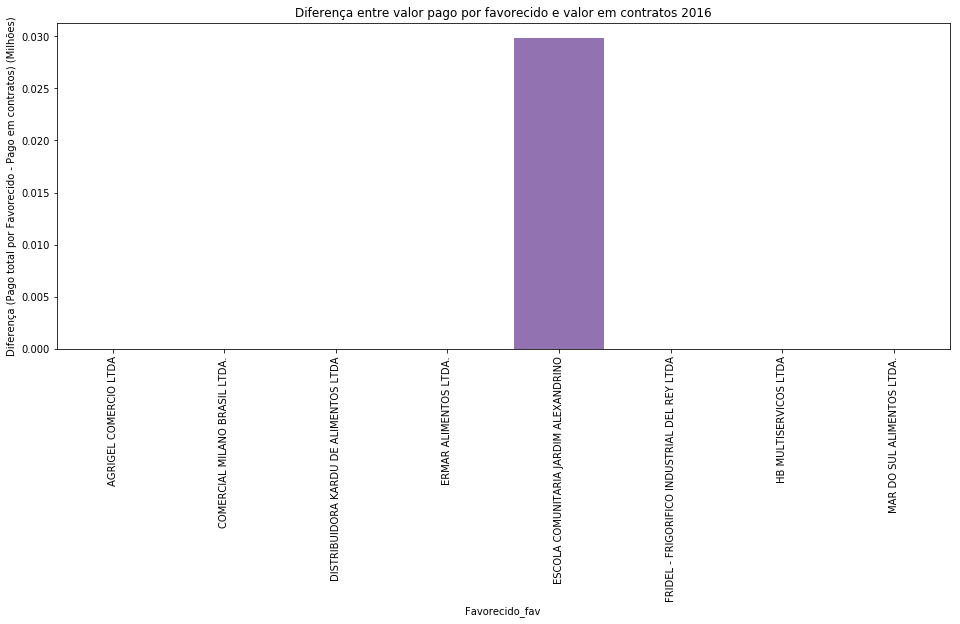

In [13]:
df_fav_2016 = get_ds_favorecidos(2016)
df_cont_2016 = get_ds_contrato(2016)

pipeline_fav.run(df_fav_2016, df_cont_2016, 2016)

## 2015

/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


O valor pago em merenda correpondeu a 0.25477564644232276% do valor pago para Favorecidos no ano de 2015


/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


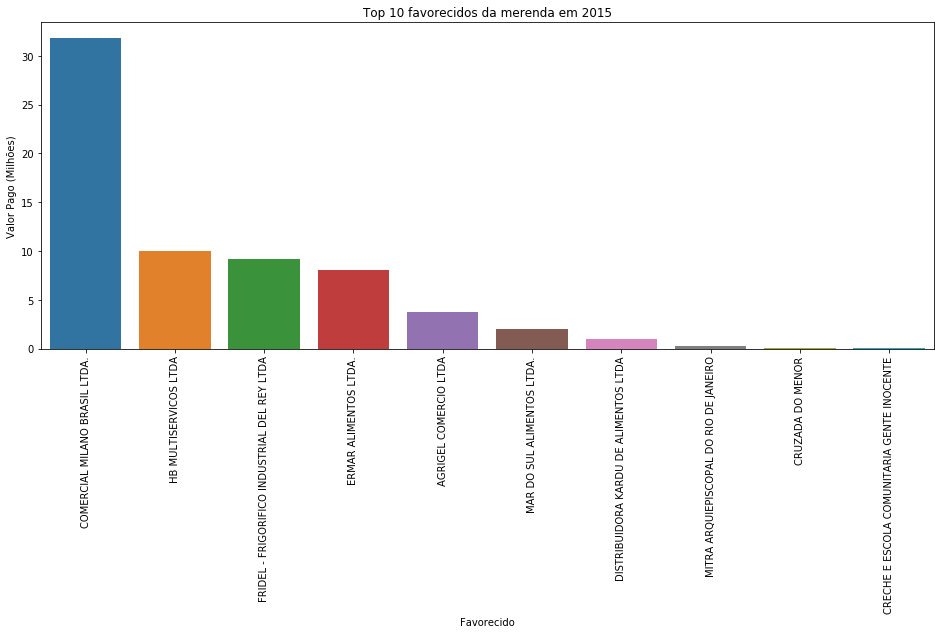

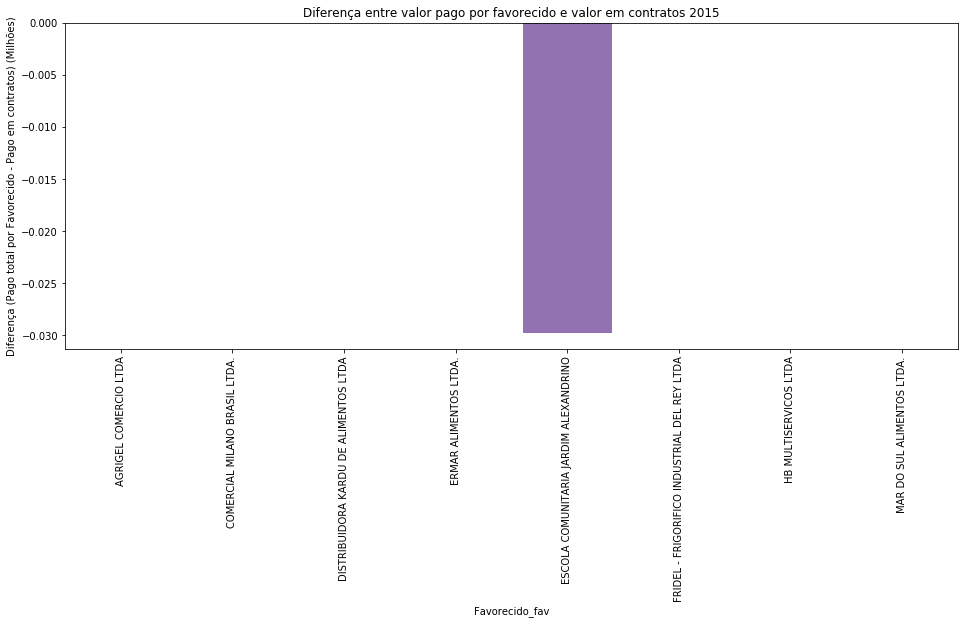

In [14]:
df_fav_2015 = get_ds_favorecidos(2015)
df_cont_2015 = get_ds_contrato(2015)

pipeline_fav.run(df_fav_2015, df_cont_2015, 2015)